# Задача проекта

- Заказчик: Благотворительный фонд “Бюро добрых дел”
- Основная цель заказчика заключается в том, чтобы из пула тех клиентов, которые жертвовали за последний год, выявить клиентов, которые могут увеличить частоту или размер пожертвований.
- Данные, которыми располагает заказчик, включают в себя историю платежей жертвователей и какую-то дополнительную информацию за несколько лет по четырём тысячам жертвователей.
- Жизненный цикл жертвователя составляет от полутора до трёх лет, поэтому в истории будут примеры того, как именно меняется характер платежей клиентов.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')
import phik
import lightgbm as lgb
import shap

In [2]:
from scipy import stats
from catboost import CatBoostClassifier
from catboost import cv, Pool
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split
from phik import resources, report
from tqdm import tqdm
from sklearn import preprocessing
from IPython.display import Image
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import roc_auc_score, roc_curve ,log_loss, plot_confusion_matrix,accuracy_score
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

# №1. Загрузка данных 

In [3]:
donors = pd.read_excel('/Users/armineagajanyan/Downloads/Выгрузка для ЯП_2.xlsx', sheet_name='Доноры')
donats = pd.read_excel('/Users/armineagajanyan/Downloads/Выгрузка для ЯП_2.xlsx', sheet_name='Пожертвования')

In [4]:
#создадим функцию для информации
def table_info(df):
    display(df.info())
    display(df.head())
    display(df.describe())
    display(df.isna().mean())
    return df

# Датасет donors

In [5]:
table_info(donors)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   ID                               3683 non-null   object        
 1   Пол                              2431 non-null   object        
 2   Город                            1015 non-null   object        
 3   Дата последней email активности  1835 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 115.2+ KB


None

,ID,Пол,Город,Дата последней email активности
0,AF575B85-917F-475D-8875-00055586E05B,NaN,NaN,NaT
1,229A9B43-3A15-4A48-8CB6-000EDB240D50,NaN,NaN,NaT
2,C6606486-05A8-4437-ACF9-00344E54FEE1,NaN,NaN,NaT
3,6ED86154-A688-4A11-868F-006209035413,Женский ...,NaN,NaT
4,46C41E20-EA56-4698-9C37-00692FD6FFE8,Женский ...,NaN,NaT


Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.


,ID,Пол,Город,Дата последней email активности
count,3683,2431,1015,1835
unique,3683,2,234,653
top,AF575B85-917F-475D-8875-00055586E05B,Женский ...,Москва,2022-07-18 16:29:49
freq,1,1874,458,294
first,NaN,NaN,NaN,2020-01-30 11:41:46
last,NaN,NaN,NaN,2022-07-28 20:34:28


ID                                 0.000000
Пол                                0.339940
Город                              0.724409
Дата последней email активности    0.501765
dtype: float64

,ID,Пол,Город,Дата последней email активности
0,AF575B85-917F-475D-8875-00055586E05B,NaN,NaN,NaT
1,229A9B43-3A15-4A48-8CB6-000EDB240D50,NaN,NaN,NaT
2,C6606486-05A8-4437-ACF9-00344E54FEE1,NaN,NaN,NaT
3,6ED86154-A688-4A11-868F-006209035413,Женский ...,NaN,NaT
4,46C41E20-EA56-4698-9C37-00692FD6FFE8,Женский ...,NaN,NaT
...,...,...,...,...
3678,C5E55606-9BFC-48C0-BE7F-FFC10A10DF20,Женский ...,NaN,NaT
3679,3CB754A9-7B08-40FB-A350-FFDB291DA9E1,NaN,NaN,NaT
3680,3F073C3B-E567-428E-B16F-FFE09A8D2CE0,Женский ...,NaN,2022-07-18 16:29:34
3681,029C3CEE-2381-4050-8E91-FFE3030218D4,Женский ...,КУШВА,NaT


In [6]:
donors['Пол'].value_counts(dropna=False).to_frame()


,Пол
Женский,1874
NaN,1252
Мужской,557


In [7]:
#топ 10 городов
donors['Город'].value_counts(dropna=False).to_frame().head(10)

,Город
NaN,2668
Москва,458
Санкт-Петербург,78
Краснодар,23
Нижний Новгород,20
Новосибирск,19
Якутск,14
Саратов,13
Ростов-на-Дону,12
Казань,11


Вывод 
- ID -уникальный идентификатор жертвователя
- пол - пол жертвователя
- Город - город поступления пожервования                              
- Дата последней email активности


- датасет donors содержит 4 столбца и 3683 строк
- во всех столбцах есть пропущенные значения во всех столбцах
  

# Датасет donats

In [8]:
table_info(donats)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14043 entries, 0 to 14042
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Donor ID            14043 non-null  object        
 1   Дата платежа        14043 non-null  datetime64[ns]
 2   Сумма платежа       14043 non-null  float64       
 3   Рекуррентный        14043 non-null  object        
 4   Назначение платежа  12774 non-null  object        
 5   Канал оплаты        14043 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 658.4+ KB


None

,Donor ID,Дата платежа,Сумма платежа,Рекуррентный,Назначение платежа,Канал оплаты
0,DE5393F9-9585-4057-B7FB-24B69697FC08,2022-07-03 19:49:48,300.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты
1,81CD4BEF-443E-4D36-B34F-664E11182D65,2020-03-14 12:20:02,300.0,Нет ...,SMS bdd,SMS
2,D3BEB76D-D8B6-47E2-8109-44F1B278943B,2022-04-07 00:00:00,16.0,Нет ...,Добровольное пожертвование. НДС не облагается,Прямые поступления на счет
3,F1310736-B229-4AAC-99B7-F13ACECF67CB,2019-12-26 02:25:42,300.0,Нет ...,NaN,SMS
4,61C3D86B-39DA-445C-9D7F-9924CE9BDA14,2021-06-26 01:26:07,200.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты


,Сумма платежа
count,1.404300e+04
mean,1.720846e+03
std,2.949977e+04
min,1.000000e-02
25%,1.500000e+02
50%,3.500000e+02
75%,7.000000e+02
max,3.000000e+06


Donor ID              0.000000
Дата платежа          0.000000
Сумма платежа         0.000000
Рекуррентный          0.000000
Назначение платежа    0.090365
Канал оплаты          0.000000
dtype: float64

,Donor ID,Дата платежа,Сумма платежа,Рекуррентный,Назначение платежа,Канал оплаты
0,DE5393F9-9585-4057-B7FB-24B69697FC08,2022-07-03 19:49:48,300.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты
1,81CD4BEF-443E-4D36-B34F-664E11182D65,2020-03-14 12:20:02,300.0,Нет ...,SMS bdd,SMS
2,D3BEB76D-D8B6-47E2-8109-44F1B278943B,2022-04-07 00:00:00,16.0,Нет ...,Добровольное пожертвование. НДС не облагается,Прямые поступления на счет
3,F1310736-B229-4AAC-99B7-F13ACECF67CB,2019-12-26 02:25:42,300.0,Нет ...,NaN,SMS
4,61C3D86B-39DA-445C-9D7F-9924CE9BDA14,2021-06-26 01:26:07,200.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты
...,...,...,...,...,...,...
14038,0B6DA68C-558B-4153-806E-B1D775585B88,2015-12-12 14:50:34,100.0,Да ...,Пожертвование в фонд помощи детям-отказникам и...,Банковские карты
14039,793690C0-6332-4289-96B4-2CF8902ACEF5,2020-12-02 09:59:13,200.0,Да ...,ПОЖЕРТВОВАНИЕ,Банковские карты
14040,69613503-5B71-4690-ACB5-8E783FF915B4,2021-12-26 00:00:00,500.0,Нет ...,Добровольное пожертвование. НДС не облагается,Прямые поступления на счет
14041,144B2E46-2A6A-48DE-92FB-729C3897A2B4,2018-11-27 16:35:01,200.0,Да ...,Пожертвование в фонд помощи детям-отказникам и...,Банковские карты


In [9]:
donats['Дата платежа'].min(), donats['Дата платежа'].max()

(Timestamp('2015-07-19 20:10:11'), Timestamp('2022-07-28 19:22:15'))

<AxesSubplot:>

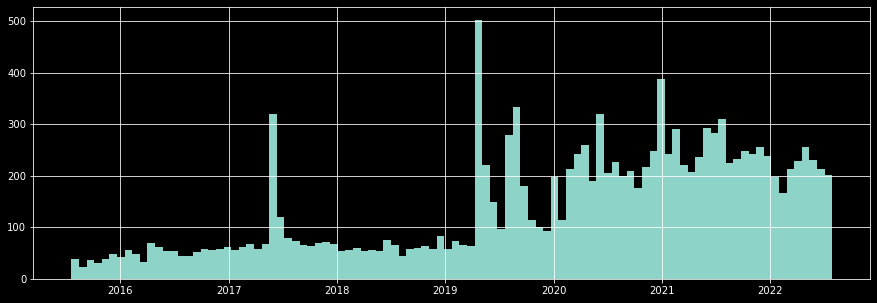

In [10]:
donats['Дата платежа'].hist(figsize = (15, 5), bins=100)

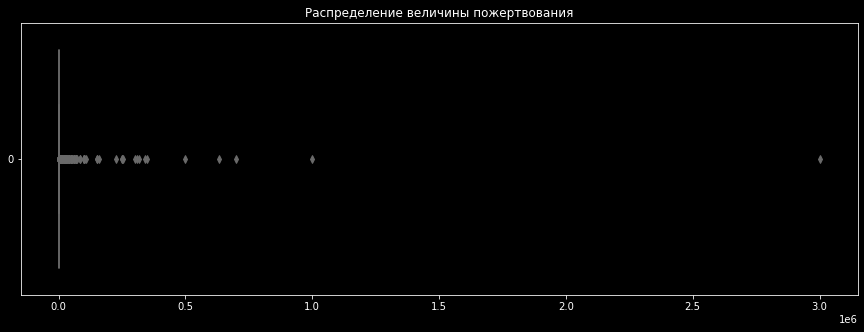

In [11]:

plt.figure(figsize=(15,5))
sns.boxplot(data=donats['Сумма платежа'], orient = 'h')
plt.title('Распределение величины пожертвования')
plt.show()

In [12]:
donats['Сумма платежа'].describe().round()

count      14043.0
mean        1721.0
std        29500.0
min            0.0
25%          150.0
50%          350.0
75%          700.0
max      3000000.0
Name: Сумма платежа, dtype: float64

In [13]:
donats['Рекуррентный'].value_counts(dropna=True).to_frame()

,Рекуррентный
Да,8085
Нет,5958


In [14]:
donats['Назначение платежа'].value_counts(dropna=True).to_frame().head(70)

,Назначение платежа
ПОЖЕРТВОВАНИЕ,3811
"Пожертвование в фонд помощи детям-отказникам и детям-сиротам ""Бюро Добрых Дел""",3335
ПОЖЕРТВОВАНИЕ undefined,2162
Добровольное пожертвование. НДС не облагается,497
SMS bdd,253
...,...
На обучение Дарьи,12
Фотомастерская для Февронии,11
На программу Окно в мир,11
День рождения со смыслом,11


- Donor ID - уникальный идентификатор клиента             
- Дата платежа - начальная дата транзакции       
- Сумма платежа - сумма пожервования         
- Рекуррентный - является ли жервователь рекуррентным         
- Назначение платежа - цель пожервования      
- Канал оплаты - способ оплаты
 
Вывод
- датасет Donor содержит 6 столбцов и 14043 строк
- есть пропущенные значений в столбце 'Назначение платежа' 



Вывод 

датасет donor 
- Donor ID - уникальный идентификатор жертвователя            
- Дата платежа - начальная дата транзакции       
- Сумма платежа - сумма пожертвования         
- Рекуррентный - является ли жертвователь рекуррентным         
- Назначение платежа - цель пожертвования      
- Канал оплаты - способ оплаты

- датасет donor содержит 6 столбцов и 14043 строк
- есть пропущенные значений в столбце 'Назначение платежа' 


датасет donats 
- ID -уникальный идентификатор жертвователя
- пол - пол жертвователя
- Город - город поступления пожертвования                              
- Дата последней email активности


- датасет donats содержит 4 столбца и 3683 строк
- во всех столбцах есть пропущенные значения

С методом describe() посмотрели cумму платежа и построили график с усами, обнаружили что есть очень большие выбросы, которые надо детально анализировать.

# 2. Предобработка данных

In [15]:
# сравним количество уникальных id в обеих датасетах
print('Количество уникальных идентификаторов  в датасете donors:',len(donors['ID'].unique()))
print('Количество уникальных идентификаторов в датасете donats:', len(donats['Donor ID'].unique()))

Количество уникальных идентификаторов  в датасете donors: 3683
Количество уникальных идентификаторов в датасете donats: 3683


In [16]:
#проверим на дубликаты
print('Количество дубликатов в датасете donors:', donors.duplicated().sum())
print('Количество дубликатов в датасете donats:', donats.duplicated().sum())

Количество дубликатов в датасете donors: 0
Количество дубликатов в датасете donats: 12


In [17]:
#donats[donats.duplicated() == True]
#удаляем дубликаты и проверяем
donats = donats.drop_duplicates()
donats.duplicated().sum()

0

In [18]:
# т.к. количество уникальных id равны, объединим таблицы в одну,
# предварительно переименовав столбец в donats

donats = donats.rename(columns={'Donor ID' : 'ID'})

df = donats.merge(donors, how='left', on = 'ID')
df.head(2)

,ID,Дата платежа,Сумма платежа,Рекуррентный,Назначение платежа,Канал оплаты,Пол,Город,Дата последней email активности
0,DE5393F9-9585-4057-B7FB-24B69697FC08,2022-07-03 19:49:48,300.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты,Женский ...,Москва,2022-06-03 20:15:57
1,81CD4BEF-443E-4D36-B34F-664E11182D65,2020-03-14 12:20:02,300.0,Нет ...,SMS bdd,SMS,Женский ...,Москва,2022-07-18 17:19:02


In [19]:
# переименуем столбцы, приведя их к змеиному (snake case) регистру
df = df.rename(columns = 
              {
                  'ID':'id',
                  'Дата платежа':'date',
                  'Сумма платежа':'amount',
                  'Пол':'gender',
                  'Город':'city',
                  'Назначение платежа' : 'purpose',
                  'Рекуррентный' : 'is_reccurent',
                  'Канал оплаты' : 'channel',
                  'Дата последней email активности': 'last_email_activity'
                  
              }
              )
df.columns

Index(['id', 'date', 'amount', 'is_reccurent', 'purpose', 'channel', 'gender',
       'city', 'last_email_activity'],
      dtype='object')

In [20]:
# посмотрим процентное соотношение пропусков
df.isna().mean()

id                     0.000000
date                   0.000000
amount                 0.000000
is_reccurent           0.000000
purpose                0.090443
channel                0.000000
gender                 0.111824
city                   0.519849
last_email_activity    0.210819
dtype: float64

In [21]:
#заполним пропуски в категориальных признаков no_info 
for column in ['gender', 'purpose']:            
    df[column].fillna('no_info', inplace=True)

In [22]:
df['gender'] = df['gender'].str.strip()

In [23]:
#напишем функцию для категоризации городов

def city_category(city):
    foreign_cities = ['Frankfurt am Main', 'Charleston', 'Helsinki', 'Juba', 'Copenhagen', 'Holon', 
                     'Hyderabad', 'Alameda', 'Jakarta', 'Keighley', 'Southall', 'Denver']
    
    if city.loc['city'] == 'Москва':
        return 'Москва'
    elif city.loc['city'] == 'Санкт-Петербург':
        return 'Санкт-Петербург'
    elif city.loc['city'] in foreign_cities:
        return 'Зарубежные страны'
    elif city.loc['city'] == 0:
        return 'Город неизвестен'
    else:
        return 'Другие города России'

df['city'] = df['city'].fillna(0)
# применим функцию
df['city'] = df.apply(city_category, axis=1)
df.head(2)

,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity
0,DE5393F9-9585-4057-B7FB-24B69697FC08,2022-07-03 19:49:48,300.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты,Женский,Москва,2022-06-03 20:15:57
1,81CD4BEF-443E-4D36-B34F-664E11182D65,2020-03-14 12:20:02,300.0,Нет ...,SMS bdd,SMS,Женский,Москва,2022-07-18 17:19:02


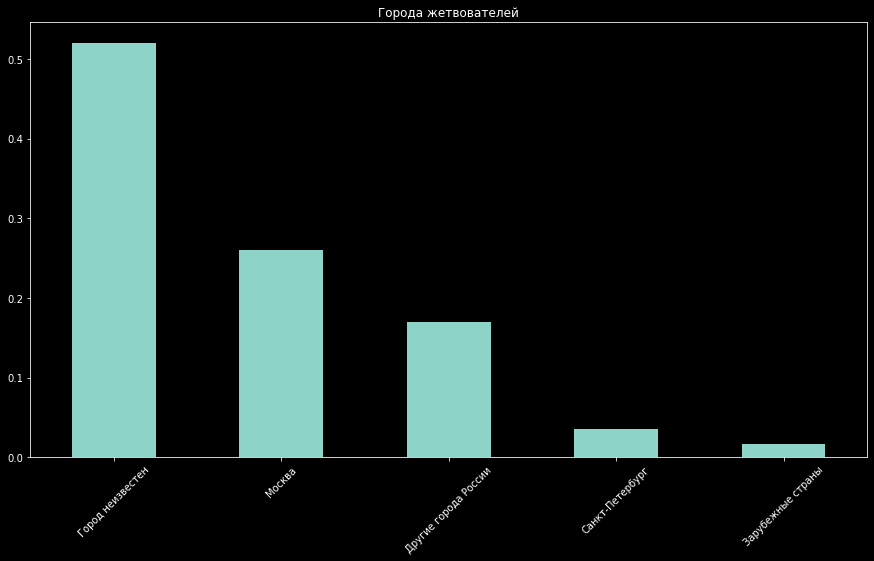

In [24]:
(df['city'].value_counts()/len(df['id'])).plot(
    title='Города жетвователей',
    kind='bar', 
    figsize=(15,8),
    rot=45
);

In [25]:
#приведем датасет к нижнему регистру
df = df.apply(lambda x: x.str.lower() if(x.dtype == 'object') else x)

In [26]:

# в столбце 'is_reccurent' содержатся значения со множеством пробелов
# заменим их на более удобные 
df['is_reccurent'] = df['is_reccurent'].replace('да                                                                                                                                                                                                                                                        ',
                                                 1)
df['is_reccurent'] = df['is_reccurent'].replace('нет                                                                                                                                                                                                                                                       ',
                                                  0)

In [27]:
# заполним пропуски в столбце 'purpose' и 'last_email_activity'
df['purpose'].fillna('no_info', inplace=True)
df['last_email_activity'].fillna(0, inplace=True)

In [28]:
# заменим в столбце  'last_email_activity' получили email на 1, не получили - 0
df['last_email_activity'] = 1
df.loc[df["last_email_activity"]==0, 'last_email_activity'] = 0

In [29]:
# напишем функцию для категоризации назначения платежа
def purose_category(purpose):
    
    if 'на обучение' in purpose.loc['purpose']:
        return 'обучение'
    elif 'sms' in purpose.loc['purpose']:
        return 'sms'
    elif 'пожертвование' in purpose.loc['purpose']:
        return 'пожертвование'
    else:
        return 'на другие цели'


# применим функцию
df['purpose'] = df.apply(purose_category, axis=1)
df.head()

,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity
0,de5393f9-9585-4057-b7fb-24b69697fc08,2022-07-03 19:49:48,300.0,1,пожертвование,банковские карты,женский,москва,1
1,81cd4bef-443e-4d36-b34f-664e11182d65,2020-03-14 12:20:02,300.0,0,sms,sms,женский,москва,1
2,d3beb76d-d8b6-47e2-8109-44f1b278943b,2022-04-07 00:00:00,16.0,0,пожертвование,прямые поступления на счет,мужской,город неизвестен,1
3,f1310736-b229-4aac-99b7-f13acecf67cb,2019-12-26 02:25:42,300.0,0,на другие цели,sms,no_info,город неизвестен,1
4,61c3d86b-39da-445c-9d7f-9924ce9bda14,2021-06-26 01:26:07,200.0,1,пожертвование,банковские карты,женский,город неизвестен,1


In [30]:
# доля назначений пожертвований
(df['purpose'].value_counts()/len(df['id']))

пожертвование     0.772290
на другие цели    0.145749
обучение          0.063930
sms               0.018032
Name: purpose, dtype: float64

<AxesSubplot:title={'center':'Назначения платежей'}>

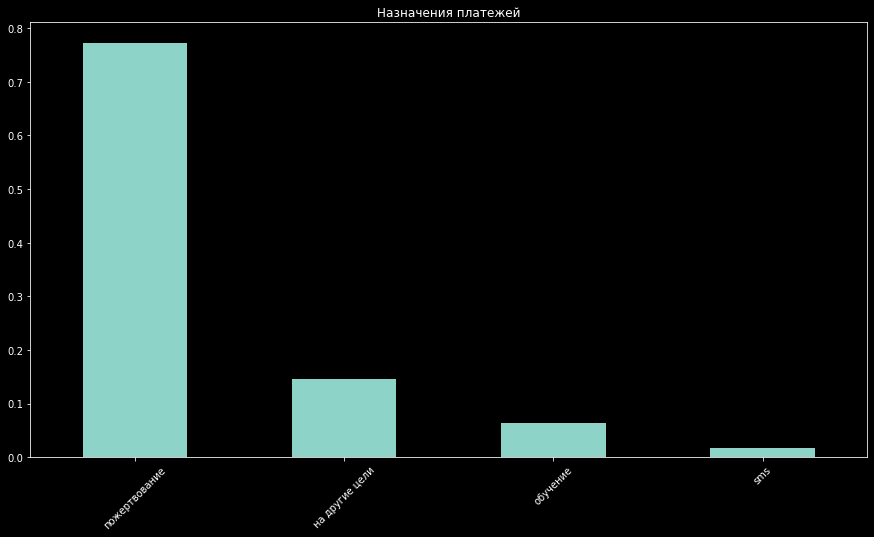

In [31]:
# Назначения платежей
(df['purpose'].value_counts()/len(df['id'])).plot(title='Назначения платежей',
    kind='bar',
    figsize=(15,8),
    rot=45)
 

In [32]:
# проверим пропуски
df.isna().mean()

id                     0.0
date                   0.0
amount                 0.0
is_reccurent           0.0
purpose                0.0
channel                0.0
gender                 0.0
city                   0.0
last_email_activity    0.0
dtype: float64

In [33]:
#добавляем столбцы год, месяц, день 
df['date_day'] =df['date'].dt.day
df['date_month'] =df['date'].dt.month
df['date_year'] =df['date'].dt.year
df.head()

,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity,date_day,date_month,date_year
0,de5393f9-9585-4057-b7fb-24b69697fc08,2022-07-03 19:49:48,300.0,1,пожертвование,банковские карты,женский,москва,1,3,7,2022
1,81cd4bef-443e-4d36-b34f-664e11182d65,2020-03-14 12:20:02,300.0,0,sms,sms,женский,москва,1,14,3,2020
2,d3beb76d-d8b6-47e2-8109-44f1b278943b,2022-04-07 00:00:00,16.0,0,пожертвование,прямые поступления на счет,мужской,город неизвестен,1,7,4,2022
3,f1310736-b229-4aac-99b7-f13acecf67cb,2019-12-26 02:25:42,300.0,0,на другие цели,sms,no_info,город неизвестен,1,26,12,2019
4,61c3d86b-39da-445c-9d7f-9924ce9bda14,2021-06-26 01:26:07,200.0,1,пожертвование,банковские карты,женский,город неизвестен,1,26,6,2021


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14031 entries, 0 to 14030
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   14031 non-null  object        
 1   date                 14031 non-null  datetime64[ns]
 2   amount               14031 non-null  float64       
 3   is_reccurent         14031 non-null  int64         
 4   purpose              14031 non-null  object        
 5   channel              14031 non-null  object        
 6   gender               14031 non-null  object        
 7   city                 14031 non-null  object        
 8   last_email_activity  14031 non-null  int64         
 9   date_day             14031 non-null  int64         
 10  date_month           14031 non-null  int64         
 11  date_year            14031 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(5)
memory usage: 1.4+ MB


Вывод
новый датасет df:
- датасет df содержит 12  столбцов и 14031 строк

- id - уникальный идентификатор жертвователя
- date - начальная дата транзакции 
- date_day - день транзакции 
- date_month - месяц транзакции 
- date_year - год транзакции 
- amount - сумма пожертвования
- is_reccurent -является ли жертвователь рекуррентным 
- purpose  - назначение платежа
- channel - способ пожертвования 
- gender - пол жертвователя
- city - город поступления пожертвования
- last_email_activity - дата последней email активности

Выполнили следующее:
- заменили названия столбцов, датасет привели к нижнему регистру, удалили пробелы
- заполнили пропущенные значения в столбцах 'purpose','last_email_activity','gender' на 'no_info', так как при анализе данных получим не точные результаты
- изменили типы данных
- удалили дубликаты  
- написали функцию для категоризации городов и назначения платежа
- добавили столбцы: год, месяц, день 
- заменили в столбце 'last_email_activity':
    -   получили email - 1
    -   не получили - 0
- заменили в столбце 'is_reccurent': 
    -   рекуррентный - 1 
    -   не рекуррентный - 0 


# №3. Исследовательский анализ данных

In [35]:
#построим таблицу от сумм пожертвования по рекуррентности по годам
df_amount_count_sum= df.pivot_table(index='date_year', values='amount', aggfunc=['sum','count','median','mean','var','std','max','min'])
df_amount_count_sum.columns = ['sum','count','median','mean','var','std','max','min']
df_amount_count_sum

,sum,count,median,mean,var,std,max,min
date_year,,,,,,,,
2015,398605.00,227,456.0,1755.969163,9.544411e+06,3089.402954,20000.0,6.00
2016,953593.91,761,500.0,1253.080039,2.132163e+07,4617.534617,85000.0,10.00
2017,1133535.68,1252,400.0,905.379936,1.158627e+07,3403.861563,100000.0,1.00
2018,879666.00,855,500.0,1028.849123,9.133342e+06,3022.142037,50000.0,10.00
2019,10171042.06,2455,300.0,4142.990656,4.677194e+09,68390.013365,3000000.0,1.00
2020,4494441.52,3195,300.0,1406.710961,1.297071e+08,11388.901780,500000.0,0.01
2021,3970621.94,3547,450.0,1119.431052,3.783888e+07,6151.331491,250000.0,0.01
2022,2164154.55,1739,500.0,1244.482202,7.771531e+07,8815.628491,250000.0,0.22


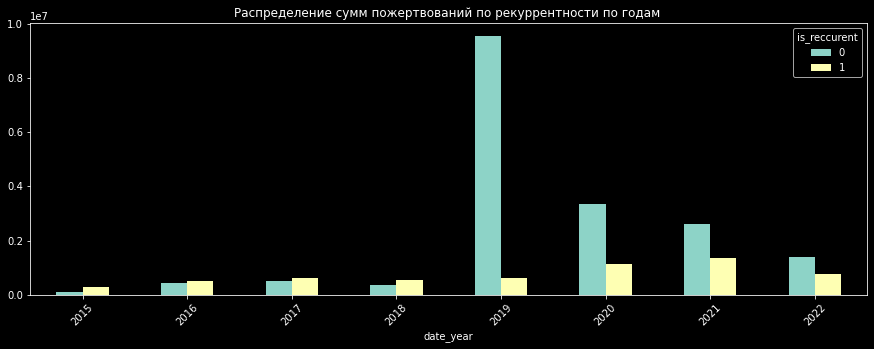

In [36]:
df_amount_sum=(df
     .pivot_table(index='date_year', columns = 'is_reccurent', values='amount', aggfunc='sum')
     .plot(figsize=(15,5),kind='bar', rot=45, title = 'Распределение сумм пожертвований по рекуррентности по годам ')
)

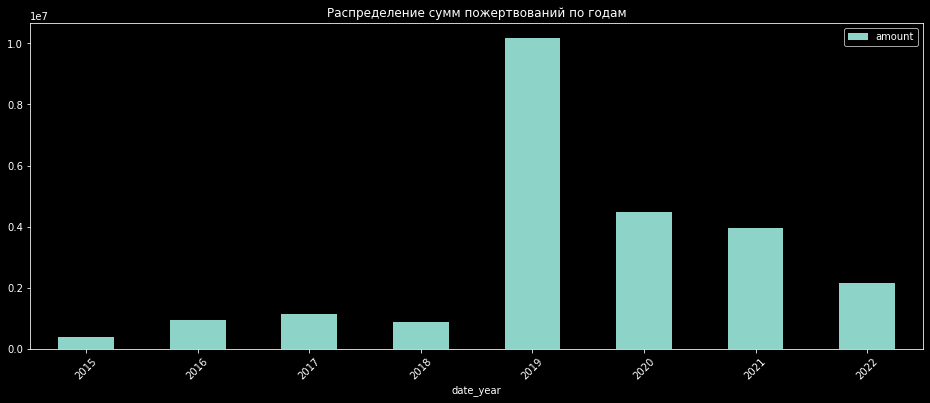

In [37]:
df_amount_count=(df
     .pivot_table(index='date_year', values='amount', aggfunc='sum')
     .plot(figsize=(16,6),kind='bar', title = 'Распределение сумм пожертвований по годам',rot=45)
)

In [38]:
df.pivot_table(index = 'date_year', columns='is_reccurent',  values = 'id', aggfunc='count')

is_reccurent,0,1
date_year,,
2015,35,192
2016,113,648
2017,499,753
2018,172,683
2019,1787,668
2020,1424,1771
2021,1309,2238
2022,607,1132


<AxesSubplot:title={'center':'Распределение количества жертвователей по рекуррентности по годам '}, xlabel='date_year'>

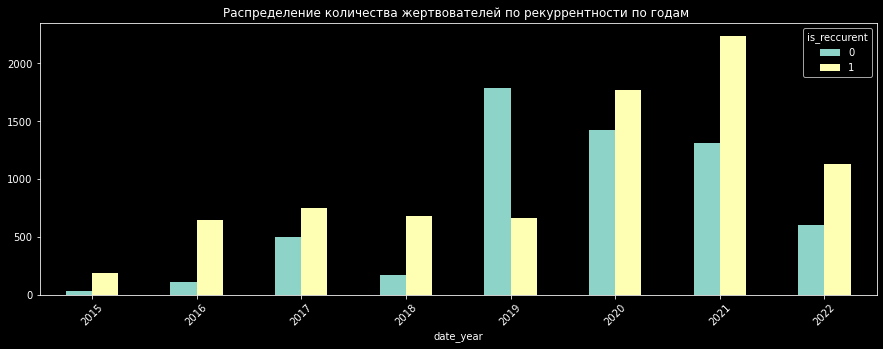

In [39]:
(
     df
    .pivot_table(index = 'date_year', columns='is_reccurent',  values = 'id', aggfunc = 'count')
    .plot
    .bar(figsize =(15, 5), title = 'Распределение количества жертвователей по рекуррентности по годам ', rot=45)
)

Вывод\
из сводных таблиц и графиков видно, что:
- сумма пожертвований растет и достигает максимума в 2019 г, а в 2020 и 2021 годах сумма снижается (за 2022 данные только до 28.07.2022г), 
- сумма пожертвований и количество нерекуррентных жертвователей уменьшается в 2020 и 2021 годах, возможно это связано с COVID-19, так как были запрещены общественные мероприятия, а сумма пожертвований и количество рекуррентых жертвователей с каждым годом растет.

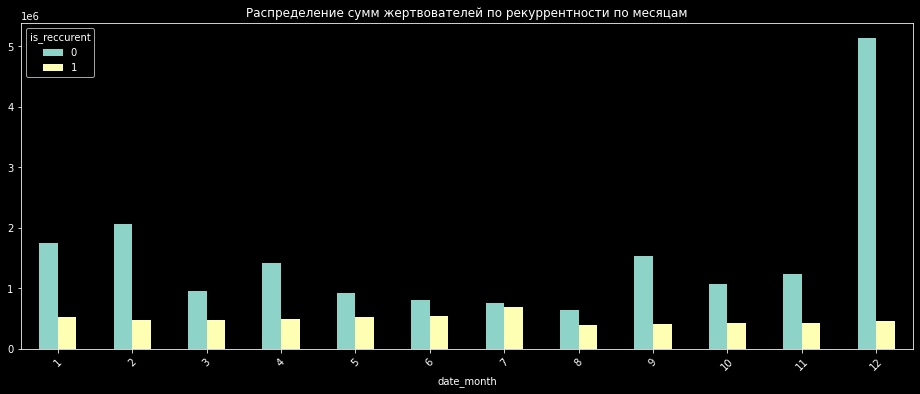

In [40]:
df_amount=(df
     .pivot_table(index='date_month', columns = 'is_reccurent', values='amount', aggfunc='sum')
     .plot(figsize=(16,6),kind='bar',rot=45, title = 'Распределение сумм жертвователей по рекуррентности по месяцам')
)

Вывод\
из графика видно, что суммы пожертвований у рекуррентных жертвователей распределяются равномерно по месяцам,а у нерекуррентных жертвователей пик в декабре (возможно это связано с новогодними праздниками), летом уменьшается (возможно это связано с отпускным периодом).  

In [41]:
df_reccurent = df.groupby(['is_reccurent'])['amount'].agg(['count','sum', 'mean', 'median']).sort_values(by='count', ascending=False)
df_reccurent

,count,sum,mean,median
is_reccurent,,,,
1,8085,5857796.00,724.526407,500.0
0,5946,18307864.66,3079.021974,300.0


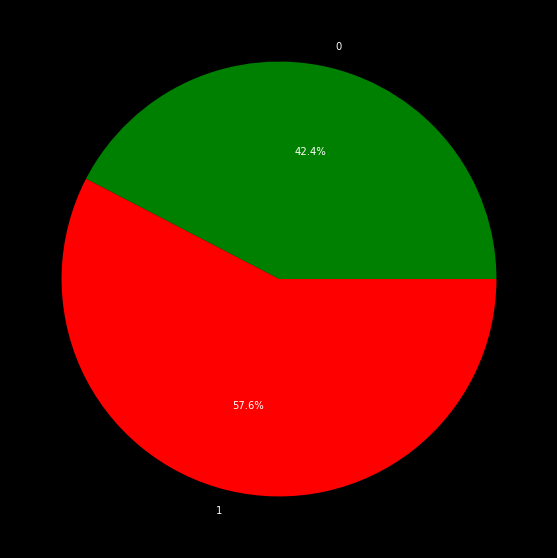

In [42]:
x=df.groupby("is_reccurent")["is_reccurent"].count()
reccurent = x.index
plt.figure(figsize=(10,10))
colors = ["g","r","y"]
plt.pie(x=x, labels=reccurent,colors = colors, autopct='%.1f%%')
plt.show()

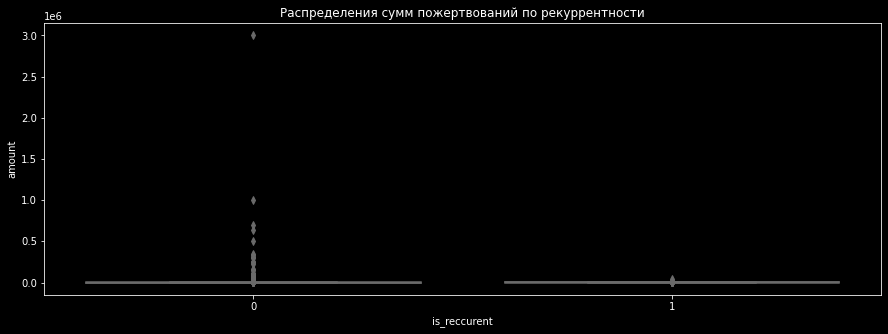

In [43]:
plt.figure(figsize=(15,5))
sns.boxplot(x=df["is_reccurent"], y=df['amount'])
plt.title('Распределения сумм пожертвований по рекуррентности')
plt.show()

 Вывод
- несмотря на то, что количестово рекуррентных жертвователей составляет 57.6%, суммах пожертвований у нерекуррентных жертвователей 3 раза больше  
- из графика видно, что в суммах пожертвований у нерекуррентных жертвователей есть выбросы

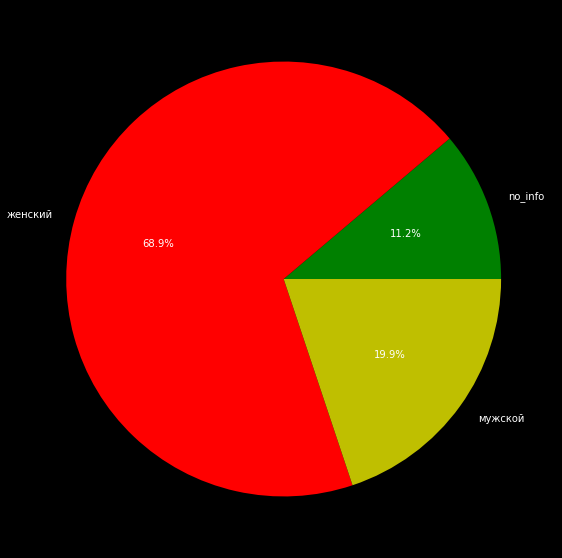

In [44]:
#
x=df.groupby("gender")['gender'].count()
gender = x.index
plt.figure(figsize=(10,10))
colors = ["g","r","y"]
plt.pie(x=x, labels=gender,colors = colors, autopct='%.1f%%')
plt.show()

<AxesSubplot:title={'center':'Распределение сумм жертвователей по рекуррентности в зависимости от пола '}, xlabel='gender'>

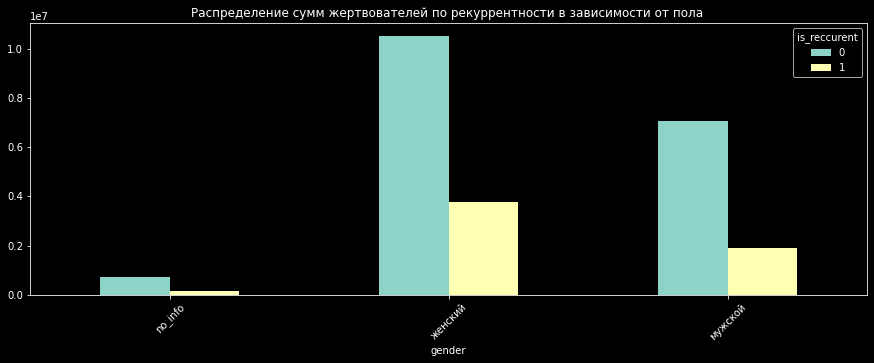

In [45]:
(
     df
    .pivot_table(index = 'gender', columns='is_reccurent',  values = 'amount', aggfunc = 'sum')
    .plot
    .bar(figsize =(15, 5), title = 'Распределение сумм жертвователей по рекуррентности в зависимости от пола ', rot=45)
)

In [46]:
df.pivot_table(index = 'gender', columns='is_reccurent',  values = 'amount', aggfunc = ['count','sum','median'])

count                sum            median       
is_reccurent     0     1            0          1      0      1
gender                                                        
no_info       1418   151    724724.00   150000.0  200.0  300.0
женский       3443  6231  10508765.10  3787992.0  450.0  300.0
мужской       1085  1703   7074375.56  1919804.0  500.0  500.0

Вывод\
из сводных таблиц и графиков видно, что:
-  количество женщин  3 раза превышает количество мужчин
- 11.18% не указал пол, возможно есть проблемы в сборе данных.
- женщины чаще делают пожертвования, возможно из-за большей эмпатии   



<AxesSubplot:title={'center':'Распределение количества жертвователей по способу пожертвования в зависимости от пола'}, xlabel='purpose'>

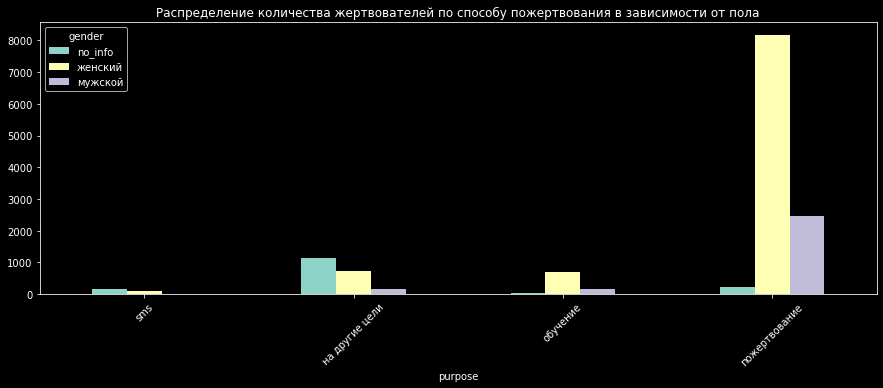

In [47]:
(
     df
    .pivot_table(index = 'purpose', columns='gender',  values = 'id', aggfunc = 'count')
    .plot
    .bar(figsize =(15, 5), title = 'Распределение количества жертвователей по способу пожертвования в зависимости от пола', rot=45)
)

<AxesSubplot:title={'center':'Распределение пожертвований по целям'}, xlabel='purpose'>

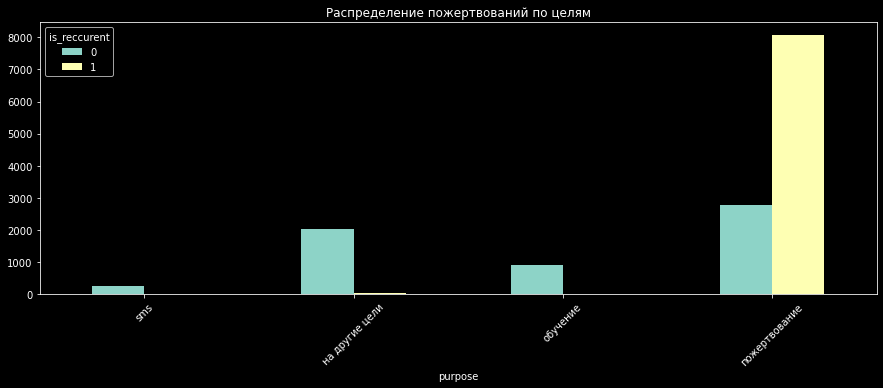

In [48]:
(
     df
    .pivot_table(index = 'purpose', columns='is_reccurent',  values = 'id', aggfunc = 'count')
    .plot
    .bar(figsize =(15, 5), title = 'Распределение пожертвований по целям', rot=45)
)

In [49]:
 df.pivot_table(index = 'purpose', columns='is_reccurent',  values = 'id', aggfunc = 'count')

is_reccurent,0,1
purpose,,
sms,253.0,NaN
на другие цели,2020.0,25.0
обучение,897.0,NaN
пожертвование,2776.0,8060.0


Вывод\
из сводных таблиц и графиков видно, что рекуррентные жертвователи в основном жертвуют в фонд



<AxesSubplot:title={'center':'Распределение жертвователей по способу пожертвования'}, xlabel='channel'>

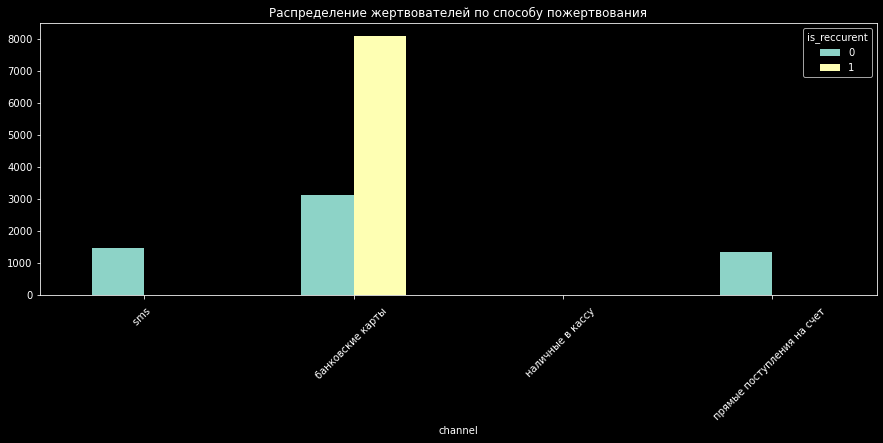

In [50]:
(
     df
    .pivot_table(index = 'channel', columns='is_reccurent',  values = 'id', aggfunc = 'count')
    .plot
    .bar(figsize =(15, 5), title = 'Распределение жертвователей по способу пожертвования', rot=45)
)

In [51]:
df.pivot_table(index = 'channel', columns='is_reccurent',  values = 'id', aggfunc = 'count')

is_reccurent,0,1
channel,,
sms,1474.0,NaN
банковские карты,3119.0,8085.0
наличные в кассу,3.0,NaN
прямые поступления на счет,1350.0,NaN


Вывод\
из сводных таблиц и графиков видно, что в основном жертвуют через банковские карты



<AxesSubplot:title={'center':'Количество жертвователей по городам'}, xlabel='city'>

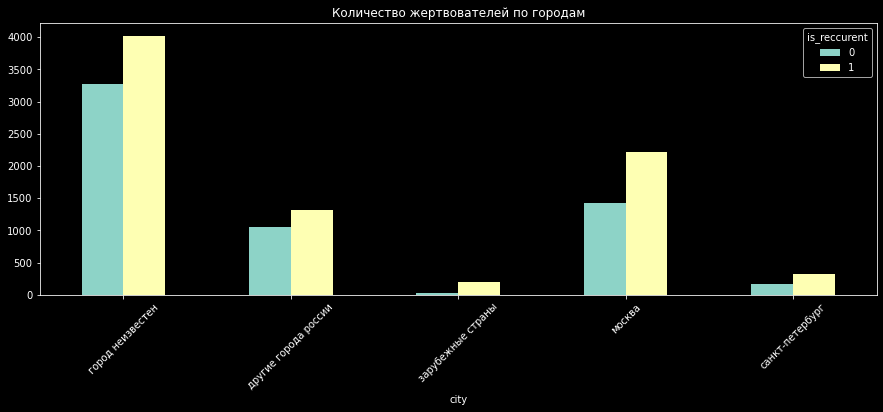

In [52]:
(
     df
    .pivot_table(index = 'city', columns='is_reccurent',  values = 'id', aggfunc = 'count')
    .plot
    .bar(figsize =(15, 5), title = 'Количество жертвователей по городам', rot=45)
)

<AxesSubplot:title={'center':'Распределение сумм пожертвований по городам жертвователей'}, xlabel='city'>

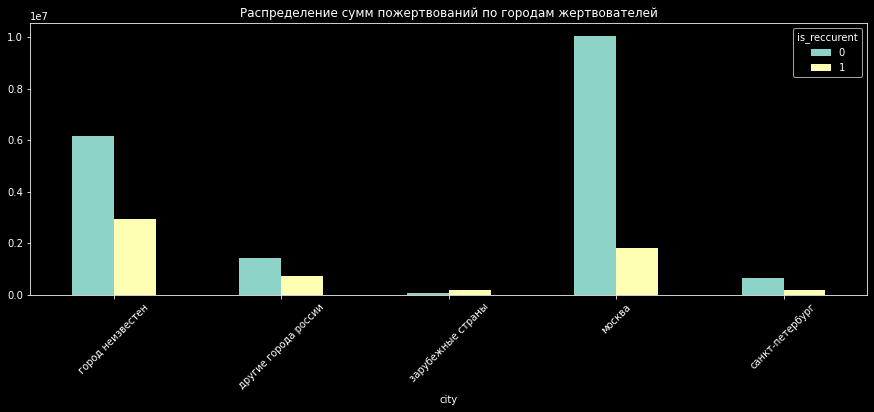

In [53]:
(
     df
    .pivot_table(index = 'city', columns='is_reccurent',  values = 'amount', aggfunc = 'sum')
    .plot
    .bar(figsize =(15, 5), title = 'Распределение сумм пожертвований по городам жертвователей', rot=45)
)

In [54]:
df.pivot_table(index = 'city', values = 'amount', aggfunc = ['count','sum'])

,count,sum
,amount,amount
city,,
город неизвестен,7294,9078598.01
другие города россии,2374,2147334.49
зарубежные страны,226,245325.00
москва,3643,11878614.00
санкт-петербург,494,815789.16


Вывод\
из сводных таблиц и графиков видно, что жертвуют больше всего из Москвы



In [55]:
df_sum_count = df.groupby(['id'])['amount'].agg(['count','sum', 'mean', 'median','std']).sort_values(by='count', ascending=False)
df_sum_count

,count,sum,mean,median,std
id,,,,,
8a8daecd-40b3-4a41-b53c-06a62be672e6,83,129500.0,1560.240964,1000.0,730.008313
0b6da68c-558b-4153-806e-b1d775585b88,76,13500.0,177.631579,200.0,41.948172
f836f738-fb7e-4134-aba8-b6e9ca1e71ea,76,2280.0,30.000000,30.0,0.000000
85348172-f358-4345-91f1-db8cf0531c8a,73,17202.0,235.643836,100.0,744.534761
4ecb767f-8830-497b-b395-851d4eacd1f8,65,93500.0,1438.461538,1500.0,286.515874
...,...,...,...,...,...
6246ed33-cf41-4f33-88f3-7002a436e483,1,100.0,100.000000,100.0,NaN
6254900a-bddc-4b1d-ab9a-9877b9e7bc77,1,500.0,500.000000,500.0,NaN
62602f1f-b33b-4a10-a17a-aea4adb4791d,1,300.0,300.000000,300.0,NaN


In [56]:
df_sum_count.describe().round()

,count,sum,mean,median,std
count,3683.0,3683.0,3683.0,3683.0,1039.0
mean,4.0,6561.0,2963.0,2881.0,1342.0
std,8.0,67201.0,53504.0,53479.0,10203.0
min,1.0,0.0,0.0,0.0,0.0
25%,1.0,150.0,100.0,100.0,0.0
50%,1.0,500.0,300.0,300.0,22.0
75%,2.0,1500.0,561.0,500.0,223.0
max,83.0,3000000.0,3000000.0,3000000.0,170660.0


In [57]:
df_sum_count.query('count==1').count()

count     2644
sum       2644
mean      2644
median    2644
std          0
dtype: int64

Вывод\
из сводных таблиц видно, что:
-  из 3683 жертвователей на данный день 2644 жертвовали только 1 раз.
- максимальная сумма пожертвования: 3 000 000
- максимальное количество пожертвований: 83 
- среднее и медиана почти не отличаются

Вывод
- сумма пожертвований растет и достигает максимума в 2019 г, а в 2020 и 2021 годах сумма снижается (за 2022 данные только до 28.07.2022г), 
- сумма пожертвований и количество нерекуррентных жертвователей уменьшается в 2020 и 2021 годах, возможно это связано с COVID-19, так как были запрещены общественные мероприятия, а сумма пожертвований и количество рекуррентых жертвователей с каждым годом растет.
-  суммы пожертвований у рекуррентных жертвователей распределяются равномерно по месяцам,а у нерекуррентных жертвователей пик в декабре (возможно это связано с новогодними праздниками), летом уменьшается (возможно это связано с отпускным периодом).  
- несмотря на то, что количестово рекуррентных жертвователей составляет 57.6%, суммах пожертвований у нерекуррентных жертвователей 3 раза больше  
- в суммах пожертвований у нерекуррентных жертвователей есть большие выбросы
- количество женщин  3 раза превышает количество мужчин
- 11.18% не указал пол, возможно есть проблемы в сборе данных.
- женщины чаще делают пожертвования, возможно из-за большей эмпатии   
- рекуррентные жертвователи в основном жертвуют в фонд
- в основном жертвуют через банковские карты
- жертвуют больше всего из Москвы
- из 3683 жертвователей на данный день 2644 жертвовали только 1 раз.
- максимальная сумма пожертвования: 3 000 000
- максимальное количество пожертвований: 83 
- среднее и медиана почти не отличаются

# №4. Подготовка данных  для МЛ

In [58]:
# выберем период  с 2015-08-01 по 2022-07-01 (последный месяц не полный)
df_all= df[df['date'].between('2015-08-01 00:00:00', '2022-07-01 00:00:00')]

In [59]:
# сформируем отдельный датасет с информацией о каждом жертвователе 

df_all = df_all.groupby('id').agg(
    {'date': ['min', 'max'], 
     'amount':['count', 'sum','mean','median'],
     'last_email_activity':'max',
     'is_reccurent':'max',
     'gender':lambda x: stats.mode(x)[0],
     'city':lambda x: stats.mode(x)[0],
     'channel':lambda x: stats.mode(x)[0],
     'purpose':lambda x: stats.mode(x)[0]
     
    }).set_axis(
    ['first_date', 'last_date',
     'donations_count','donations_sum', 'donations_mean', 'donations_median',
     'last_email_activity',
     'is_reccurent',
     'gender',
     'city',
     'channel',
     'purpose'
    ], 
     axis=1, inplace=False).reset_index()

In [60]:
 # добавляем столбец lifetime каждого жертвователя в месяцах, иначе 'продолжительность жизни жертвователя', изменив тип данных  

df_all['lifetime'] = ((df_all['last_date'] - df_all['first_date'])/np.timedelta64(1,'D')/30)
df_all['lifetime'] = df_all['lifetime'].apply(np.floor)
df_all['lifetime'] = df_all['lifetime'].replace(0,1)
df_all['lifetime'] = df_all['lifetime'].astype(int)
df_all.head(2)

,id,first_date,last_date,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,gender,city,channel,purpose,lifetime
0,0001afdd-94e3-48f3-b5e7-d5539700425e,2019-04-26 19:19:24,2019-04-26 19:19:24,1,100.0,100.0,100.0,1,0,no_info,город неизвестен,sms,на другие цели,1
1,000711b2-2785-461b-bf5b-5cb7d2caba20,2020-03-27 08:23:58,2022-06-27 08:24:05,21,10500.0,500.0,500.0,1,1,женский,город неизвестен,банковские карты,пожертвование,27


In [61]:
# добавим столбец 'churn', выбираем тех потенциальных рекуррентных жертвователей, 
#которые в фонд жертвуют в течениие 11 месяцев 10 раз   
df_all['churn']=0

df_all.loc[((df_all['donations_count']/df_all['lifetime']>=0.9)) 
          & ((df_all['lifetime']>=11)) 
          & ((df_all['is_reccurent']==1)), 'churn'] = 1

df_all.head(2)

,id,first_date,last_date,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,gender,city,channel,purpose,lifetime,churn
0,0001afdd-94e3-48f3-b5e7-d5539700425e,2019-04-26 19:19:24,2019-04-26 19:19:24,1,100.0,100.0,100.0,1,0,no_info,город неизвестен,sms,на другие цели,1,0
1,000711b2-2785-461b-bf5b-5cb7d2caba20,2020-03-27 08:23:58,2022-06-27 08:24:05,21,10500.0,500.0,500.0,1,1,женский,город неизвестен,банковские карты,пожертвование,27,0


In [62]:
df_all.describe().round()

,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,churn
count,3656.0,3656.0,3656.0,3656.0,3656.0,3656.0,3656.0,3656.0
mean,4.0,6514.0,2978.0,2894.0,1.0,0.0,5.0,0.0
std,8.0,67401.0,53701.0,53675.0,0.0,0.0,10.0,0.0
min,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
25%,1.0,150.0,100.0,100.0,1.0,0.0,1.0,0.0
50%,1.0,500.0,300.0,300.0,1.0,0.0,1.0,0.0
75%,2.0,1500.0,565.0,500.0,1.0,0.0,1.0,0.0
max,82.0,3000000.0,3000000.0,3000000.0,1.0,1.0,82.0,1.0


In [63]:
df_all['churn'].value_counts(normalize=True)

0    0.93709
1    0.06291
Name: churn, dtype: float64

In [64]:
# выберем период  с 2015-08-01 по 2022-06-01 (последный месяц оставим для тестирования)
df_train = df[df['date'].between('2015-08-01 00:00:00', '2021-07-01 00:00:00')].copy()

In [65]:
df_train = df_train.groupby('id').agg(
    {'date': ['min', 'max'], 
     'amount':['count', 'sum','mean','median'],
     'last_email_activity':'max',
     'is_reccurent':'max',
     'gender':lambda x: stats.mode(x)[0],
     'city':lambda x: stats.mode(x)[0],
     'channel':lambda x: stats.mode(x)[0],
     'purpose':lambda x: stats.mode(x)[0]
     
    }).set_axis(
    ['first_date', 'last_date',
     'donations_count','donations_sum', 'donations_mean', 'donations_median',
     'last_email_activity',
     'is_reccurent',
     'gender',
     'city',
     'channel',
     'purpose'
    ], 
     axis=1, inplace=False).reset_index()

In [66]:
# добавляем столбец lifetime: каждого жертвователя в месяцах, иначе 'продолжительность жизни жертвователя' изменив тип данных  

df_train['lifetime'] = ((df_train['last_date'] - df_train['first_date'])/np.timedelta64(1,'D')/30)
df_train['lifetime'] = df_train['lifetime'].apply(np.floor)
df_train['lifetime'] = df_train['lifetime'].replace(0,1)
df_train['lifetime'] = df_train['lifetime'].astype(int)
df_train.head(2)

,id,first_date,last_date,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,gender,city,channel,purpose,lifetime
0,0001afdd-94e3-48f3-b5e7-d5539700425e,2019-04-26 19:19:24,2019-04-26 19:19:24,1,100.0,100.0,100.0,1,0,no_info,город неизвестен,sms,на другие цели,1
1,000711b2-2785-461b-bf5b-5cb7d2caba20,2020-03-27 08:23:58,2021-06-27 08:24:05,13,6500.0,500.0,500.0,1,1,женский,город неизвестен,банковские карты,пожертвование,15


In [67]:
# добавим столбец 'churn', выбираем тех потенциальных рекуррентных жертвователей, 
#которые в фонд жертвуют в течениие 11 больше месяцев 10 раз     
df_train['churn']=0

df_train.loc[((df_train['donations_count']/df_train['lifetime']>=0.9)) 
          & ((df_train['lifetime']>=11)) 
          & ((df_train['is_reccurent']==1)), 'churn'] = 1

df_train.head(2)

,id,first_date,last_date,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,gender,city,channel,purpose,lifetime,churn
0,0001afdd-94e3-48f3-b5e7-d5539700425e,2019-04-26 19:19:24,2019-04-26 19:19:24,1,100.0,100.0,100.0,1,0,no_info,город неизвестен,sms,на другие цели,1,0
1,000711b2-2785-461b-bf5b-5cb7d2caba20,2020-03-27 08:23:58,2021-06-27 08:24:05,13,6500.0,500.0,500.0,1,1,женский,город неизвестен,банковские карты,пожертвование,15,0


Посмотрим линейную зависимость между числовыми переменными: корреляция Пирсона \
Построим парный график, чтобы понять взаимосвязь между всеми возможными парами числовых переменных
 


In [68]:
# посмотрим значения числовых признаков 
df_all[[ 'donations_count', 'donations_sum','lifetime','is_reccurent',
       'donations_mean', 'donations_median']].describe().round()
        
       

,donations_count,donations_sum,lifetime,is_reccurent,donations_mean,donations_median
count,3656.0,3656.0,3656.0,3656.0,3656.0,3656.0
mean,4.0,6514.0,5.0,0.0,2978.0,2894.0
std,8.0,67401.0,10.0,0.0,53701.0,53675.0
min,1.0,0.0,1.0,0.0,0.0,0.0
25%,1.0,150.0,1.0,0.0,100.0,100.0
50%,1.0,500.0,1.0,0.0,300.0,300.0
75%,2.0,1500.0,1.0,0.0,565.0,500.0
max,82.0,3000000.0,82.0,1.0,3000000.0,3000000.0


Количественные признаки у жертвователя


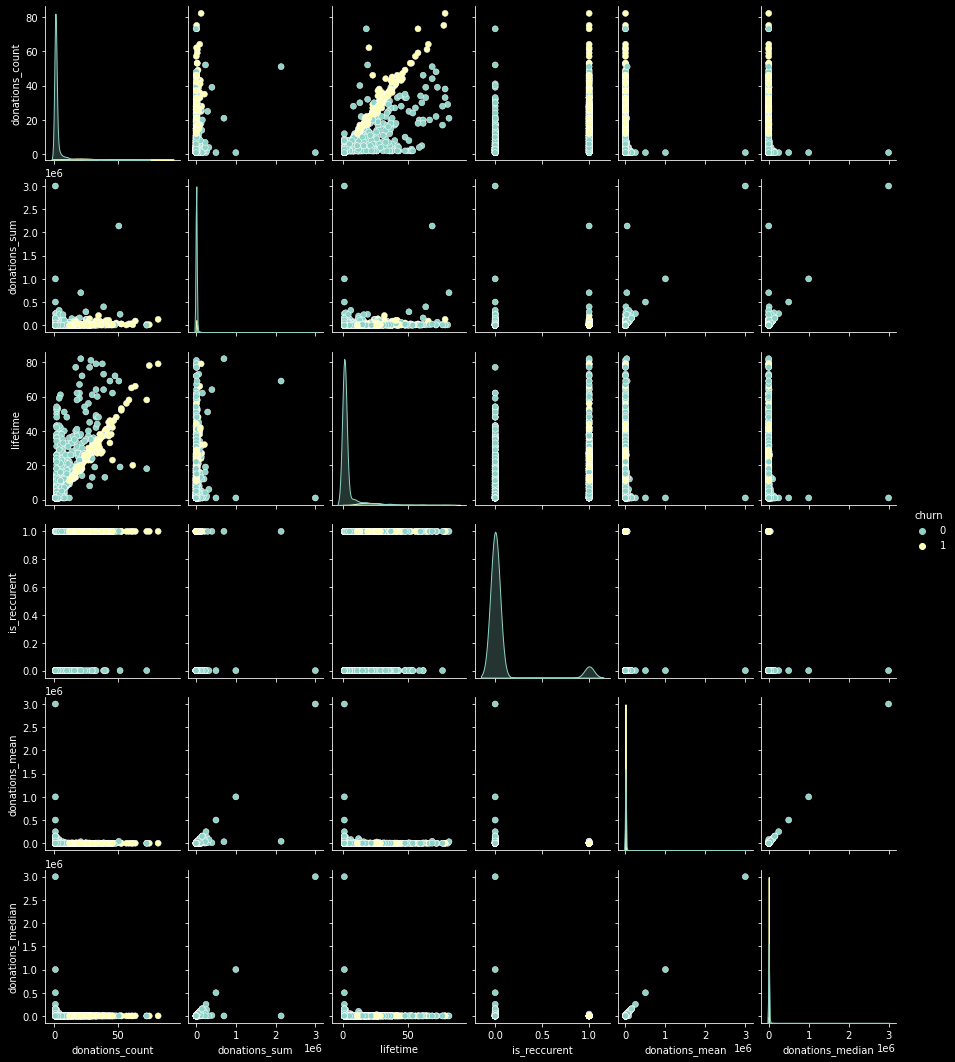

In [69]:
# Посмотрим на количественные признаки
print('Количественные признаки у жертвователя')
sns.pairplot(df_all[[ 'donations_count', 'donations_sum','lifetime','is_reccurent',
       'donations_mean', 'donations_median', 'churn']], aspect=.85, hue='churn')#, aspect=.85, hue='churn')
#df_new[[ 'donations_count', 'donations_sum','lifetime','is_reccurent',
#       'donations_mean', 'donations_median']].corr().style.background_gradient()

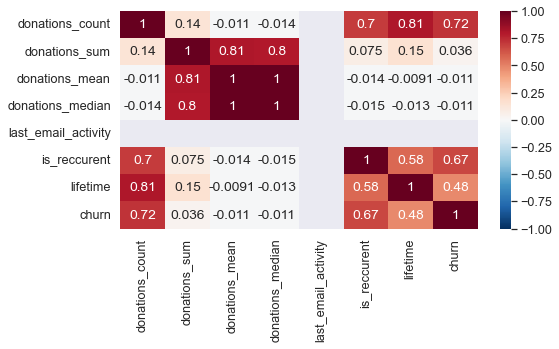

In [70]:
#построим  heatmap
sns.set(font_scale=1.15)
plt.figure(figsize=(8,4))
sns.heatmap(
    df_all.corr(),        
    cmap='RdBu_r', 
    annot=True, 
    vmin=-1, vmax=1); 

Вывод
- корреляция Пирсона больше 0.80 между 'lifetime', 'is_reccurent' и 'donations_count' 
- сильная связь есть между 'lifetime' и 'is_reccurent': корреляция Пирсона 0.58


In [71]:
#df_new = df_new[df_new['last_date'].between('2021-07-01 00:00:00', '2022-07-01 00:00:00')].copy()
df_all
df_all.query('is_reccurent==1').describe().round()

,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,churn
count,475.0,475.0,475.0,475.0,475.0,475.0,475.0,475.0
mean,18.0,19519.0,1023.0,794.0,1.0,1.0,20.0,0.0
std,13.0,106982.0,3360.0,2192.0,0.0,0.0,16.0,1.0
min,1.0,10.0,5.0,5.0,1.0,1.0,1.0,0.0
25%,8.0,2100.0,200.0,200.0,1.0,1.0,9.0,0.0
50%,15.0,5100.0,467.0,500.0,1.0,1.0,17.0,0.0
75%,25.0,12500.0,740.0,500.0,1.0,1.0,27.0,1.0
max,82.0,2138889.0,41939.0,40000.0,1.0,1.0,82.0,1.0


- Посмотрим нелинейнную зависимомость между признаками
- Корреляция Фика 

In [72]:
#корреляция Фика (нелинейнная зависимомость между признаками)
phik_overview = df_all.phik_matrix()

interval columns not set, guessing: ['donations_count', 'donations_sum', 'donations_mean', 'donations_median', 'last_email_activity', 'is_reccurent', 'lifetime', 'churn']


The number of unique values of variable first_date is large: 3495. Are you sure this is not an interval variable? Analysis for pairs of variables including first_date can be slow.
The number of unique values of variable id is large: 3656. Are you sure this is not an interval variable? Analysis for pairs of variables including id can be slow.
The number of unique values of variable last_date is large: 3490. Are you sure this is not an interval variable? Analysis for pairs of variables including last_date can be slow.
Not enough unique value for variable last_email_activity for analysis 1. Dropping this column
/opt/anaconda3/lib/python3.9/site-packages/phik/bivariate.py:241: UserWarning: Many cells: 12759440. Are interval variables set correctly?
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/phik/bivariate.py:241: UserWarning: Many cells: 12197550. Are interval variables set correctly?
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/phik/bivariate.py:241: UserWa

In [73]:
#важность признаков в датасете 
phik_overview['churn'].sort_values(ascending=False)

id                  1.000000
first_date          1.000000
last_date           1.000000
churn               1.000000
donations_count     0.928015
is_reccurent        0.867635
lifetime            0.805211
purpose             0.378219
channel             0.146630
gender              0.108192
city                0.107707
donations_sum       0.000000
donations_mean      0.000000
donations_median    0.000000
Name: churn, dtype: float64

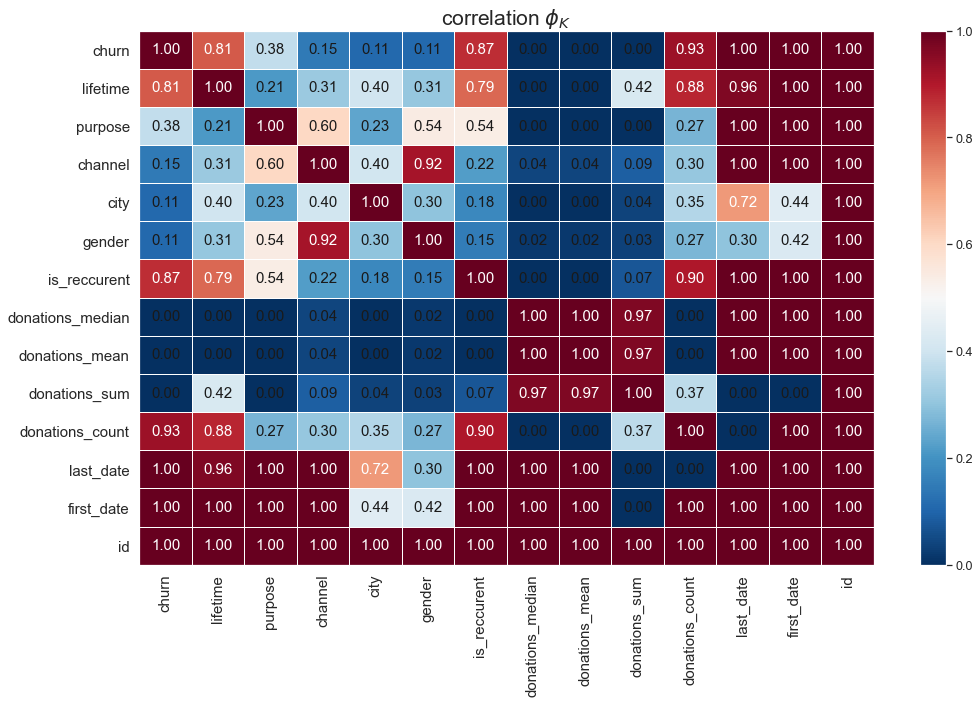

In [74]:

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='RdBu_r', 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 10))
plt.tight_layout()

На целевой признак больше всего влияют: 

- donations_count     0.928015
- is_reccurent        0.867635
- lifetime            0.805211
- purpose             0.378219


Вывод
- сформировали отдельный датасет с информацией о каждом жертвователе 
- id - уникальный идентификатор жертвователя                
- first_date - начальная дата транзакции         
- last_date - последная дата транзакции       
- churn - целевой признак           
- donations_count - количестов пожертвовании    
- is_reccurent - является ли жертвователь рекуррентным        
- lifetime - 'продолжительность жизни жертвователя' в месяцах          
- purpose  - назначение платежа            
- channel - способ пожертвования             
- gender - пол жертвователя             
- city - город поступления пожертвования              
- donations_sum - сумма пожертвования      
- donations_mean - средняя сумма пожертвования     
- donations_median - медианная сумма пожертвования    
- last_email_activity - дата последней email активности

- churn - целевой признак (выбираем тех потенциальных рекуррентных жертвователей, 
которые в фонд жертвуют в течениие 11 больше месяцев 10 раз)  

посмотрели линейную зависимость между числовыми переменными: корреляция Пирсона и
построили парный график, чтобы понять взаимосвязь между всеми возможными парами числовых переменных и обнаружили
- корреляция Пирсона больше 0.80 между 'lifetime', 'is_reccurent' и 'donations_count' 
- сильная связь есть между 'lifetime' и 'is_reccurent': корреляция Пирсона 0.58

посмотрели нелинейнную зависимость между признаками: корреляция Фика  и обнаружили важность признаков
- donations_count     0.928015
- is_reccurent        0.867635
- lifetime            0.805211
- purpose             0.378219



# №5.  Модель CatBoostClassifier

In [75]:

#разбиваем на 2 части: обучающую (2015-08-01 - 2022-06-01) и тестовую (2022-06-01 - 2022-07-01)

train = df_train[df_train['last_date'].between('2015-08-01 00:00:00', '2021-07-01 00:00:00')]
test = df_all[df_all['last_date'].between('2021-07-01 00:00:00', '2022-07-01 00:00:00')]
print(f"Среднее в обучающей выборке: {train['churn'].mean()}")
print(f"Среднее в тестовой выборке: {test['churn'].mean()}")
print(f"Количество записей в обучающей выборке: {train.shape}")
print(f"Количество записей в тестовой выборке: {test.shape}")

Среднее в обучающей выборке: 0.057499239428049895
Среднее в тестовой выборке: 0.20596205962059622
Количество записей в обучающей выборке: (3287, 15)
Количество записей в тестовой выборке: (738, 15)


In [76]:
train.columns

Index(['id', 'first_date', 'last_date', 'donations_count', 'donations_sum',
       'donations_mean', 'donations_median', 'last_email_activity',
       'is_reccurent', 'gender', 'city', 'channel', 'purpose', 'lifetime',
       'churn'],
      dtype='object')

In [77]:
# список призноков
X = [ 'donations_count', 'donations_sum','city', 'donations_median',
       'channel','is_reccurent', 'lifetime', 'gender', 'purpose','last_email_activity' ]
    
      
# список целевого признака

y=['churn']

#список категориальных признаков
cat_features =['gender', 'city', 'purpose', 'channel']

In [78]:
params = {'cat_features': cat_features,
          'eval_metric': 'AUC',
          'loss_function': 'Logloss',
          'learning_rate': 0.01,
          'depth': 2,
          'random_seed': 42,
          'verbose':10,
          'iterations': 500}

In [79]:

train_data = Pool(data=train[X],
                  label=train[y],
                 cat_features=cat_features
                 )

In [80]:
cv_data = cv(
    params = params,
    pool = train_data,
    verbose=False,
    fold_count=5,
    plot="True",
    shuffle=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.9996604414
bestIteration = 498

Training on fold [1/5]

bestTest = 0.9989388795
bestIteration = 343

Training on fold [2/5]

bestTest = 0.9988964346
bestIteration = 384

Training on fold [3/5]

bestTest = 0.9978743304
bestIteration = 388

Training on fold [4/5]

bestTest = 1
bestIteration = 430



In [81]:
cv_data

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.975091,0.016984,0.664822,0.001118,0.664805,0.001274
1,1,0.987642,0.011512,0.632694,0.002334,0.632632,0.002276
2,2,0.993757,0.000676,0.601795,0.003063,0.601745,0.003081
3,3,0.993740,0.000674,0.577179,0.003433,0.577110,0.003598
4,4,0.992412,0.001436,0.562727,0.003234,0.562655,0.003439
...,...,...,...,...,...,...,...
495,495,0.999015,0.000879,0.022711,0.005891,0.017913,0.001348
496,496,0.999015,0.000879,0.022701,0.005901,0.017885,0.001346
497,497,0.999015,0.000879,0.022673,0.005913,0.017851,0.001343
498,498,0.999023,0.000887,0.022652,0.005918,0.017816,0.001334


In [82]:
cv_data[cv_data['test-AUC-mean'] == cv_data['test-AUC-mean'].max()]

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
465,465,0.99904,0.000832,0.023179,0.005726,0.018582,0.001315
466,466,0.99904,0.000832,0.023152,0.005745,0.018544,0.001311
467,467,0.99904,0.000832,0.023133,0.005749,0.018507,0.001316
468,468,0.99904,0.000832,0.023095,0.005754,0.018475,0.001316
469,469,0.99904,0.000832,0.023084,0.005754,0.018462,0.001313
470,470,0.99904,0.000832,0.023071,0.005764,0.018446,0.001305
471,471,0.99904,0.000832,0.023073,0.005768,0.018431,0.001303
472,472,0.99904,0.000832,0.023046,0.005788,0.018406,0.001307
473,473,0.99904,0.000832,0.023039,0.005809,0.018389,0.001306
474,474,0.99904,0.000832,0.023035,0.005812,0.018373,0.001308


In [83]:
params = {'cat_features': cat_features,
          'eval_metric': 'AUC',
          'loss_function': 'Logloss',
          'learning_rate': 0.01,
          'random_seed': 42,
          'verbose':10,
          'iterations': 458,
          }

In [84]:
model = CatBoostClassifier(**params)

In [85]:
#plt.style.use('dark_background')
model.fit(train_data, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	total: 6.72ms	remaining: 3.07s
10:	total: 41.1ms	remaining: 1.67s
20:	total: 71.1ms	remaining: 1.48s
30:	total: 102ms	remaining: 1.4s
40:	total: 131ms	remaining: 1.33s
50:	total: 168ms	remaining: 1.34s
60:	total: 205ms	remaining: 1.33s
70:	total: 238ms	remaining: 1.3s
80:	total: 270ms	remaining: 1.26s
90:	total: 300ms	remaining: 1.21s
100:	total: 329ms	remaining: 1.16s
110:	total: 356ms	remaining: 1.11s
120:	total: 383ms	remaining: 1.07s
130:	total: 412ms	remaining: 1.03s
140:	total: 440ms	remaining: 990ms
150:	total: 469ms	remaining: 954ms
160:	total: 498ms	remaining: 919ms
170:	total: 533ms	remaining: 895ms
180:	total: 567ms	remaining: 867ms
190:	total: 602ms	remaining: 841ms
200:	total: 666ms	remaining: 852ms
210:	total: 701ms	remaining: 820ms
220:	total: 738ms	remaining: 791ms
230:	total: 777ms	remaining: 764ms
240:	total: 818ms	remaining: 737ms
250:	total: 857ms	remaining: 707ms
260:	total: 900ms	remaining: 679ms
270:	total: 939ms	remaining: 648ms
280:	total: 1.13s	remaining: 7

# Тестирование модели

In [86]:
predict_cat = model.predict_proba(test[X])[:, 1]
roc_auc_cat = roc_auc_score(test[y], predict_cat)
accuracy_cat = model.score(test[X], test[y])
print(f"Accuracy на тестовой выборке : {accuracy_cat:.5f}")
print(f"ROC_AUC для модели CatBoost на тестовой выборке: {roc_auc_cat:.5f}")

Accuracy на тестовой выборке : 0.97967
ROC_AUC для модели CatBoost на тестовой выборке: 0.99762


Модель | ROC_AUC на валидационной выборке | ROC_AUC на тестовой выборке | Accuracy на тестовой выборке
--- | --- | --- | ---
*CatBoostClassifier* | **0.999** | **0.997** | **0.98**


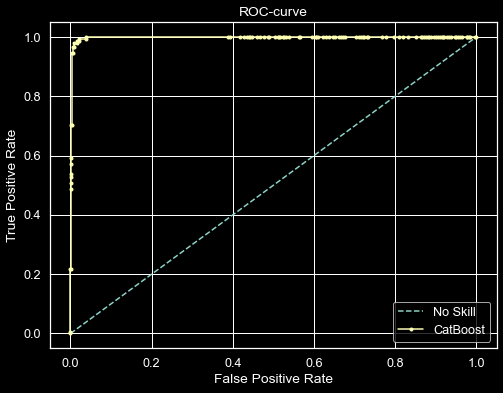

In [87]:
# построим ROC-кривую 
plt.style.use('dark_background')
fig = plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
fpr, tpr, _ = roc_curve(test[y], model.predict_proba(test[X])[:, 1])
plt.plot(fpr, tpr, marker='.', label='CatBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.legend()
plt.show()

[Text(0.5, 0, 'Predicted'),
 Text(0, 0.5, 'Actual'),
 Text(0.5, 1.0, 'Confusion Matrix Actual vs Predicted')]

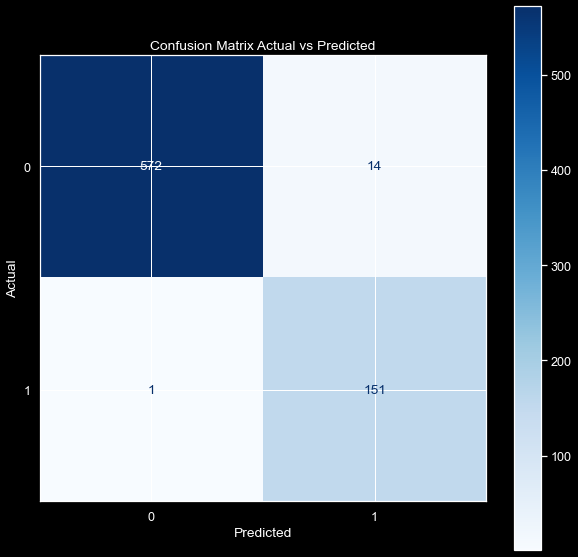

In [88]:
plt.style.use('dark_background')
# построим confusion_matrix
fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(model, test[X], test[y], ax=ax, cmap=plt.cm.Blues)
ax.set(xlabel='Predicted', ylabel='Actual', title='Confusion Matrix Actual vs Predicted')

- TP — истино-положительное решение: Интерпретация: мы предсказали положительное значения - 151
- TN — истино-отрицательное решение: Интерпретация: мы прогнозировали отрицательное значения - 572
- FP — ложно-положительное решение (Ошибка типа 1): Интерпретация: мы предсказали положительное значения - 1
- FN— ложно-отрицательное решение (Ошибка Типа 2): Интерпретация: мы предсказали отрицательное значения - 14



In [89]:
predict = model.predict(test[X])
test['pred']=predict
test_pred = test[['id','churn','pred']]
test_pred.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,id,churn,pred
1,000711b2-2785-461b-bf5b-5cb7d2caba20,0,0
2,0015a100-2d8c-4262-a9b3-bb1461c0c8b8,0,0
8,00adba34-1edc-4652-a559-1c0be379a0da,0,0
13,0112fa48-d41e-44fe-98d5-734826ce1e7c,0,0
16,013b1fc5-0c11-4b4a-b28a-183dcc530a02,0,0


In [90]:
test_pred.loc[test_pred['pred']==1]

,id,churn,pred
57,05343f01-7d7a-4147-8ece-74f6f8da69a8,1,1
66,05b8107b-349d-440b-92b0-ef081b5065a3,0,1
111,08b254b8-e5ac-4d6a-905a-b882b1f8b551,1,1
112,08c3988b-c0ff-44ee-83bf-5a75e18110d2,1,1
151,0b008efd-d8c9-4cdd-9de1-479cba5daeb9,1,1
...,...,...,...
3618,fd111b94-0e78-4440-bea2-56fb2697f647,1,1
3634,fe72a4c1-1494-4be0-b9be-76d1a1f746d6,1,1
3636,fee4bad2-de40-4fe6-8515-6c579a28dda1,1,1
3637,fee7b479-dfec-489d-8490-d6fc04bd7860,1,1


# С помощью Shap можно определить наиболее значимые факторы

In [91]:
#проверим на адекватность модели
#рассчитываем важность признаков с помощью SHAP
model.get_feature_importance(prettified=True)


,Feature Id,Importances
0,is_reccurent,36.251520
1,donations_count,28.968009
2,lifetime,18.646149
3,purpose,5.441904
4,donations_median,3.010883
5,donations_sum,2.655241
6,gender,2.618772
7,channel,1.769202
8,city,0.638319
9,last_email_activity,0.000000


Вывод\
Из таблицы видно, ответственность объекта за изменение выходных данных модели, такие как 
- is_reccurent 
- donations_count
- lifetime
- channel
- purpose\
Наша модель не увидела зависимость от last_email_activity.


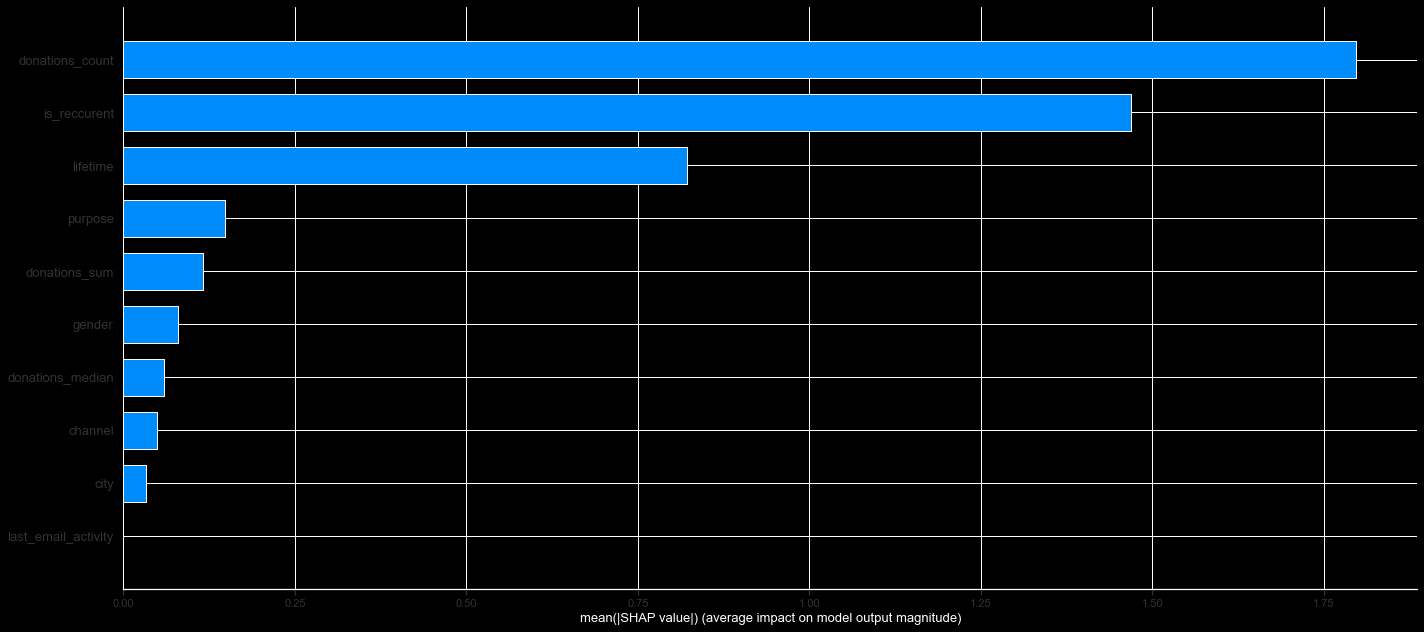

In [92]:
# построим барчарт
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test[X])
shap.summary_plot(shap_values, test[X], plot_type="bar", plot_size=(20,9))

- Чтобы понять, как отдельный объект влияет на выходные данные модели, мы можем построить график зависимости значения этого объекта от значение функции для всех примеров в наборе данных. Поскольку значения SHAP представляют ответственность объекта за изменение выходных данных модели, график ниже представляет изменение изменение целевого признака 

In [93]:
# Рассмотрим SHAP-графики. Построим такой график для каждого наблюдения в датасете
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, test[X])

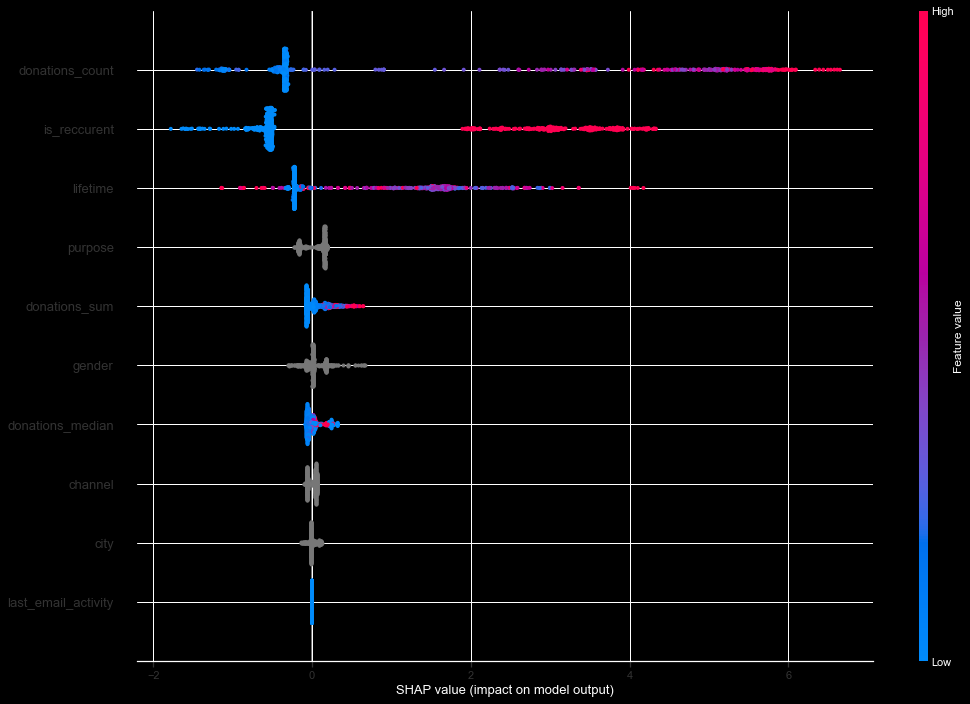

In [94]:
# сортируем объекты по сумме значений SHAP на тестовой выборке 
shap.summary_plot(shap_values, test[X], plot_size=(15,10))

- Приведенный выше график сортирует объекты по сумме значений SHAP на тестовой выборке и использует значения SHAP для отображения распределения влияния каждого объекта на выходные данные модели.

In [95]:
#посмотреть зависимость предсказаний от конкретного признака в виде 2D графика
features = model.get_feature_importance(prettified=True)['Feature Id'].values

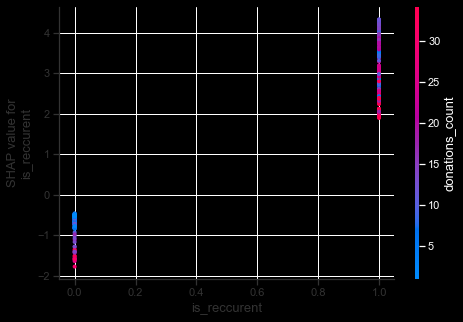

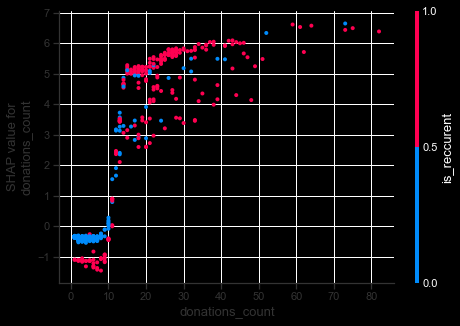

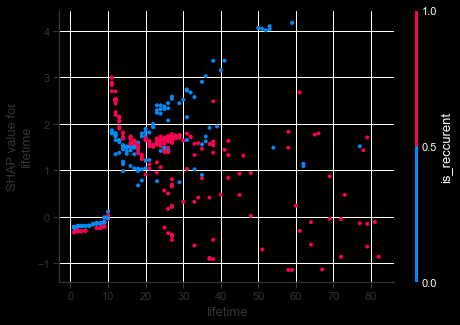

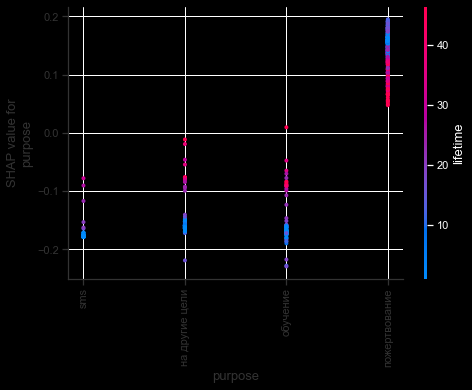

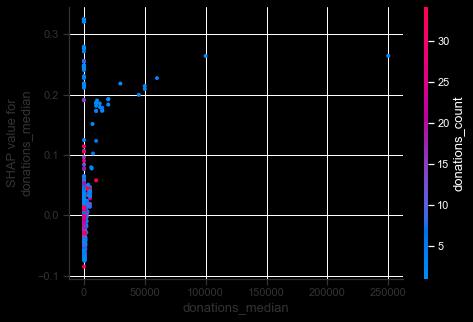

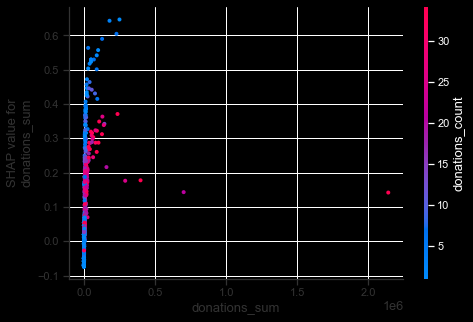

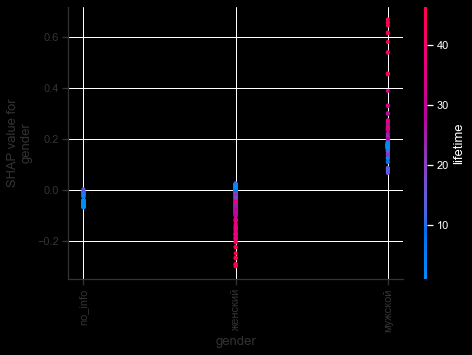

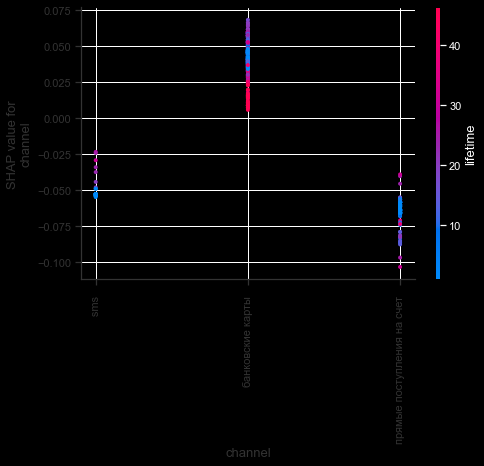

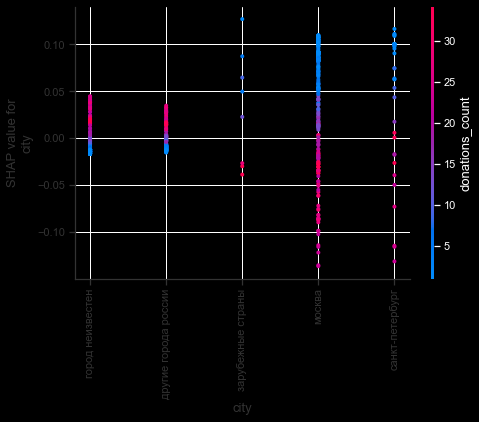

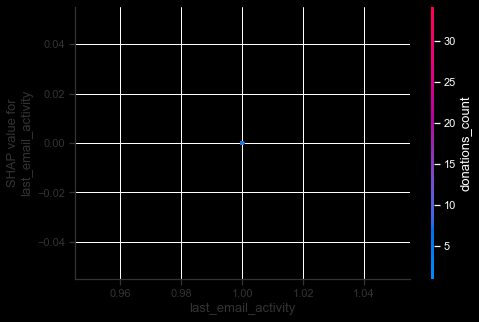

In [96]:
# посмотреть зависимость предсказаний от конкретного признака в виде 2D графика для всех признаков
for features in features:
    shap.dependence_plot(features, shap_values, test[X])

Вывод\
Таким образом, из этого графика можно сделать интересные выводы и проверить их адекватность\
На основании подобных выводов можно сформировать портрет жертвователя.
Полученные графики интерпретируется следующим образом

- рекуррентные жертвователи часто делают взносы
- больше всего жертвуют в фонд 
- способ оплаты жертвователя в основном через банковские карты
- что количество пожертвований больше всего из Москвы
- медианная сумма и общая сумма пожертвования в основном похожи, только у некоторых жертвователей отличается


Рекомендации

- Рекомендацией может быть - проведение большего числа мероприятий с учетом специфики поведения разовых и многоразовых жертвователей.
- На мой взгляд, модель машинного обучения на основе имеющихся данных не сможет корректно предсказать, так как недостаточно признаков, которые описывают поведение и фин. состояние жертвователей.